In [1]:
from fastai.basics import *
from fastai.vision import *

PATH = os.path.abspath('..')

%matplotlib inline

In [16]:
sys.path.append(f'{PATH}/src')

from ranger import Ranger

# Data

In [3]:
def split_isolated(df, reverse=False):
    """Add boolean column that is True if Sigma_5 is less than 20th percentile.

    If reverse=False, then the highest density galaxies are split out into this
    new column.
    """

    df['isolated'] = ((df.Sigma_5 < df.Sigma_5.quantile(q=0.2)) \
                      if not reverse \
                      else (df.Sigma_5 > df.Sigma_5.quantile(q=0.8)))

    return df


def get_a40(redshift_cut=True):
    """Get a40 data set """
    df = pd.read_csv(f"{PATH}/data/a40-SDSS_gas-frac.csv")

    df = df.join(pd.read_csv(f"{PATH}/data/a.40-Sigma_5.csv", index_col="AGCNr"), on="AGCNr", rsuffix='_a40')
    df = df.join(pd.read_csv(f"{PATH}/data/a40.datafile3.csv", index_col="AGCNr"), on="AGCNr", rsuffix='_sdss')

    if redshift_cut:
        return df[df.z_sdss < 0.05].copy()
    return df

In [4]:
df_lowz = get_a40()
df_underdense = split_isolated(df_lowz).copy()
df_overdense = split_isolated(df_lowz, reverse=True).copy()
df_all = get_a40(redshift_cut=False)

In [5]:
len(df_lowz), len(df_underdense), len(df_overdense), len(df_all)

(6878, 6878, 6878, 7399)

In [29]:
bs = 64
sz = 56

xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

tfms = get_transforms(
    do_flip=True,
    flip_vert=True,
    max_zoom=1.0,
    max_rotate=15.0,
    max_lighting=0,
    max_warp=0,
)

# CNN part

In [30]:
defaults.device = torch.device('cpu')

In [35]:
class SimpleCNN(nn.Module):
    def __init__(self, pretrained=False):                  # assume size = 112
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(32*14*14, 1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Low-$z$ dataset

In [36]:
data = (
    ImageList.from_df(
          df_lowz, path=PATH, folder="images-OC", suffix=".jpg", cols="AGCNr"
      )
      .split_from_df(col='isolated')
      .label_from_df(cols=["logfgas"], label_cls=FloatList)
    .transform(tfms, size=sz)
    .databunch(bs=bs)
    .normalize(xGASS_stats)
)

In [39]:
learn = learn = Learner(
        data,
        model=SimpleCNN(),
        opt_func=partial(Ranger),
        loss_func=root_mean_squared_error,
        wd=1e-3,
        bn_wd=False,
        true_wd=True,
    )

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


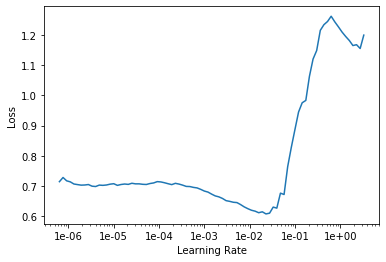

In [38]:
learn.lr_find()
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(20, 1e-2, )

epoch,train_loss,valid_loss,time
0,0.512947,0.517518,00:18
1,0.383964,0.468229,00:18


KeyboardInterrupt: 